In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import os
import idx2numpy
import time

In [2]:
data_set_path = r"F:/data_sets/MNIST/"

In [3]:
def read_idx_files(*file_names):
    data = []
    for file_name in file_names:
        array = idx2numpy.convert_from_file(data_set_path + file_name)
        if(array.ndim == 3): array = np.expand_dims(array, axis=3) #Add a channel dimension (needed for a CNN)
        data.append(array)
    return data
train_images, train_labels, test_images, test_labels = read_idx_files(
    "train-images.idx3-ubyte", "train-labels.idx1-ubyte", "t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")

In [4]:
image_height, image_width = train_images.shape[1:3]; print(train_images.shape[1:3])

(28, 28)


In [5]:
def sec2clock(s): 
    m, s = divmod(s, 60); h, m = divmod(m, 60); return "{:2.0f}:{:2.0f}:{:2.0f}".format(h, m, s)

In [6]:
graph_batch_size = None
graph = tf.Graph()
with graph.as_default():
    tf.set_random_seed(0)
    images = tf.placeholder(tf.float32, (graph_batch_size, image_height, image_width, 1))
    labels = tf.placeholder(tf.int32, (graph_batch_size,))
    conv1_filter = tf.Variable(tf.random_uniform((3, 3, 1, 5), 0.0001, 0.001))
    nn = conv1 = tf.nn.conv2d(images, conv1_filter, (1, 1, 1, 1), "SAME")
    nn = pool1 = tf.nn.max_pool(nn, (1, 2, 2, 1), (1, 2, 2, 1), "SAME")
#     nn = relu1 = tf.nn.relu(nn)
    conv2_filter = tf.Variable(tf.random_uniform((3, 3, 5, 5), 0.0001, 0.001))
    nn = conv2 = tf.nn.conv2d(nn, conv2_filter, (1, 1, 1, 1), "SAME")
    nn = pool2 = tf.nn.max_pool(nn, (1, 2, 2, 1), (1, 2, 2, 1), "SAME")
#     layer2 = relu2 = tf.nn.relu(nn)
    conv3_filter = tf.Variable(tf.random_uniform((3, 3, 5, 10), 0.0001, 0.001))
    nn = conv3 = tf.nn.conv2d(nn, conv3_filter, (1, 1, 1, 1), "SAME")
    nn = pool3 = tf.nn.max_pool(nn, (1, 2, 2, 1), (1, 2, 2, 1), "SAME")
#     nn = relu3 = tf.nn.relu(nn)
    conv4_filter = tf.Variable(tf.random_uniform((3, 3, 10, 10), 0.0001, 0.001))
    nn = conv4 = tf.nn.conv2d(nn, conv4_filter, (1, 1, 1, 1), "SAME")
    nn = pool4 = tf.nn.max_pool(nn, (1, 2, 2, 1), (1, 2, 2, 1), "SAME")
#     nn = relu4 = tf.nn.relu(nn)
    conv5_filter = tf.Variable(tf.random_uniform((3, 3, 10, 10), 0.0001, 0.001))
    nn = conv5 = tf.nn.conv2d(nn, conv5_filter, (1, 1, 1, 1), "SAME")
    nn = pool5 = tf.nn.max_pool(nn, (1, 2, 2, 1), (1, 2, 2, 1), "SAME")
#     nn = relu5 = tf.nn.relu(nn)
    dense_inputs = tf.reshape(tf.transpose(nn, (0,3,1,2)), (-1, nn.shape[1].value*nn.shape[2].value))
    dense_weights = tf.Variable(tf.random_uniform((dense_inputs.shape[1].value, 1)))
    dense_bias = tf.Variable(tf.random_uniform((1, 10)))
    dense = tf.matmul(dense_inputs, dense_weights)
    dense = tf.reshape(dense, (-1, 10))
    dense += dense_bias
    probs = tf.nn.softmax(dense)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=dense, labels=labels)
    opt = tf.train.AdamOptimizer().minimize(loss)
    init = tf.global_variables_initializer()
# trial_name = "na"
# sum_writer = tf.summary.FileWriter(os.path.join(log_dir, trial_name, "TB"), graph)
# sum_writer.flush()

In [7]:
batch_size = 25

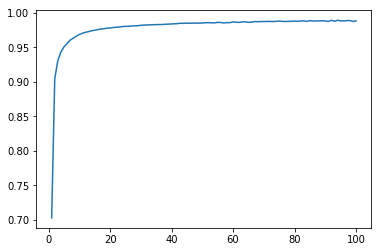

iteration: 100  -  train accuracy: 0.988  -  execution time:  1: 9:15        

In [8]:
sess = tf.Session(graph=graph)
sess.run(init)
total_iters = 0; total_time = 0; accuracies = []; x_axis = []

iters = 100
start_time = time.time()
count = train_labels.shape[0]
loss_np = np.zeros(count)
for i in range(total_iters, total_iters+iters):
    for j in range(int(np.ceil(count/batch_size))):
        start, end = (j)*batch_size, min((j+1)*batch_size, count)
        inputs, targets = train_images[start:end], train_labels[start:end]
        loss_np[start:end], _ = sess.run((loss, opt), feed_dict={images : inputs, labels : targets})
    accuracies.append(np.mean(np.exp(-loss_np)))
    
    eta = "  -  eta: {}".format(sec2clock((time.time()-start_time)*(total_iters+iters-i-1)/(i-total_iters+1)))
    exec_time = "  -  execution time: {}".format(sec2clock(total_time + time.time()-start_time))
    stats = "iteration: {}  -  train accuracy: {:.3f}{}{}".format(
        i+1, accuracies[-1], eta if i<(total_iters+iters-1) else exec_time, " "*8)
    # here accuracy is quite similar to mean of correct class probabilities
    x_axis.append(i+1)
    plt.gca().cla()
    plt.plot(x_axis, accuracies)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    display.display_pretty(stats, raw=True)
plt.close()
total_iters+=iters
total_time += time.time() - start_time

In [9]:
max_length = 1000
accuracies2 = []
for p in [[train_images, train_labels], [test_images, test_labels]]:
    for i in range(int(np.ceil(len(p[0])/max_length))):
        start, end = i * max_length, min((i+1) * max_length, len(p[0]))
        images_batch = p[0][start:end]; labels_batch = p[1][start:end]
        probs_np_batch, = sess.run([probs], feed_dict={images : images_batch, labels : labels_batch})
        probs_np = np.concatenate((probs_np, probs_np_batch)) if i!=0 else probs_np_batch
    op_labels = np.argmax(probs_np, 1)
    accuracies2.append(np.mean(op_labels==p[1]))
print("train accuracy: {:.3}  -  test accuracy: {:.3}".format(accuracies2[0], accuracies2[1]))
# here accuracy is the count of correct class examples per all examples

train accuracy: 0.993  -  test accuracy: 0.984
